In [1]:
import numpy as np
import os
from time import time
import datetime
import gc

from sklearn.metrics import accuracy_score, f1_score, auc
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_graphviz
from matplotlib import pyplot as plt
from matplotlib import colors
import pydotplus


import tensorflow.compat.v2 as tf
import tensorflow_probability as tfp
from tensorboard.plugins.hparams import api as hp

from read_dataset_for_constraint import switch_dataset, data_to_interpret

from utils import plot_boundaries_hyperrect
from sTGMA import SoftTruncatedGaussianMixtureAnalysis

from black_box import BlackBoxNN
from config import  config_params, hyper_params


from loc_func_tensorflow.kernelized import RandomFourierFeatures
import tensorflow as tf

import tensorflow_probability as tfp

tfd = tfp.distributions


/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(

In [40]:
 
dataset_name = "magic_gamma"    

X_train, y_train, X_test, y_test, y_train_onehot, y_test_onehot, scaler, color_map, column_names = \
        data_to_interpret(dataset_name, 0)

In [41]:
class quasiSVM(tf.Module):

    def __init__(self, nb_units, nb_classes, data_dim = 2):
        super(quasiSVM, self).__init__()
        self.features = RandomFourierFeatures(output_dim = nb_units[0], kernel_initializer="gaussian", trainable=True)


        self.logits = tf.keras.layers.Dense(nb_classes,  kernel_regularizer=tf.keras.regularizers.l2(0.1))
    
    @tf.function
    def __call__(self, inputs):
        x = self.features(inputs)


        return self.logits(x)

    @tf.function
    def losses(self):
        return self.logits.losses
    
    @tf.function
    def share_loss(self, X, sTGMA, weights = None):
        kl = tf.keras.losses.KLDivergence()

        def kl_divergence(x):
            return kl(
                tf.exp(
                    sTGMA.compute_log_conditional_distribution(x)
                    ),
            self.__call__(x),
            sample_weight= weights
            )


        return tfp.monte_carlo.expectation(
            f = kl_divergence,
            samples = X,
            log_prob = sTGMA.log_pdf,
               use_reparametrization= False
        )

    @tf.function
    def predict(self, X):
        return tf.nn.softmax(self.__call__(X))


In [42]:
black_box = quasiSVM(nb_units = [X_train.shape[0]], nb_classes =len(np.unique(y_train)))

optimizer_black_box = tf.optimizers.Adam(lr = 0.001)

In [49]:
@tf.function
def train_step_black_box(data, labels_one_hot, samples, weights = None, _lambda = 1.):
    cross_ent = tf.keras.losses.hinge
    with tf.GradientTape() as tape:

        #share_loss = _lambda*black_box.share_loss(X = samples,  sTGMA = model , weights = weights)
        cross_entropy = tf.reduce_mean(cross_ent(labels_one_hot, black_box(data)))

        loss = cross_entropy + black_box.losses() #+ share_loss + black_box.losses()
    gradients = tape.gradient(loss , black_box.trainable_variables)

    optimizer_black_box.apply_gradients(zip(gradients, black_box.trainable_variables))

    return cross_entropy#, share_loss #, gradients

In [50]:
list_train_acc_bb = []

list_test_acc_bb = []

save_loss1 = []

for j in range(100):
    print(f"Black-box update iteration {j}")
    loss1 = train_step_black_box(data = X_train,
                                    labels_one_hot = y_train_onehot, samples = None,
                                    weights = None,
                                    _lambda = None)
    loss1 = loss1.numpy()

    save_loss1.append(loss1)
    #save_share_loss1.append(share_loss1)

    black_box_probs = black_box(X_train)
    black_box_labels = np.argmax(black_box_probs.numpy(), axis = 1)
    
    y_train_bb = np.argmax(black_box.predict(X_train).numpy(), axis = 1)
    y_test_bb = np.argmax(black_box.predict(X_test).numpy(), axis = 1)
    train_acc_bb = accuracy_score(y_train, y_train_bb)
    test_acc_bb = accuracy_score(y_test, y_test_bb)
    
    list_train_acc_bb.append(train_acc_bb)
    list_test_acc_bb.append(test_acc_bb)

Black-box update iteration 0


TypeError: in converted code:

    <ipython-input-49-70b5f05654b9>:3 train_step_black_box  *
        cross_ent = tf.keras.losses.hinge()

    TypeError: hinge() missing 2 required positional arguments: 'y_true' and 'y_pred'


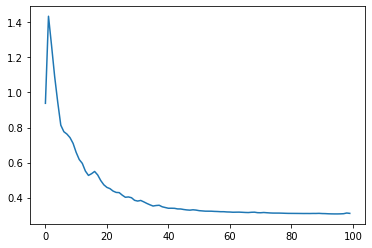

In [45]:
plt.plot(save_loss1)

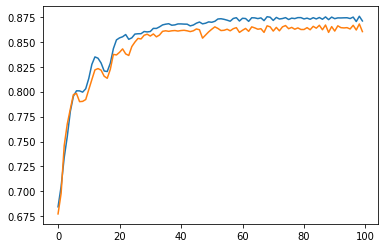

In [48]:
plt.plot(list_train_acc_bb)
plt.plot(list_test_acc_bb)

In [47]:
test_acc_bb

0.8601472134595163